## **Imports**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## **Data Loading and Helper Functions**

In [2]:
def load_data(train_path='train.csv', test_path='test.csv'):
    df_check = pd.read_csv(train_path, nrows=5, header=None)
    
    # Check if the first column of the first row is not a number
    try:
        float(df_check.iloc[0, 0])
        has_header = False
    except ValueError:
        has_header = True
        print("Header detected in CSV. Skipping first row.")

    # Load the full datasets with the correct header setting
    header_setting = 0 if has_header else None
    train_df = pd.read_csv(train_path, header=header_setting)
    
    # Note: If test.csv has no labels, it might still have a header "pixel1, pixel2..."
    # We attempt to detect header for test as well
    df_test_check = pd.read_csv(test_path, nrows=5, header=None)
    try:
        float(df_test_check.iloc[0, 0])
        test_header = None
    except ValueError:
        test_header = 0
    
    test_df = pd.read_csv(test_path, header=test_header)

    train_data = train_df.values
    
    # Split Labels and Features
    X_train = train_data[:, 1:].astype(np.float32) 
    y_train = train_data[:, 0].astype(int)
    
    X_test = test_df.values.astype(np.float32)
    
    print(f"Data Loaded. Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    return X_train, y_train, X_test

## **Part 1**

Header detected in CSV. Skipping first row.
Data Loaded. Train shape: (56000, 784), Test shape: (14000, 784)


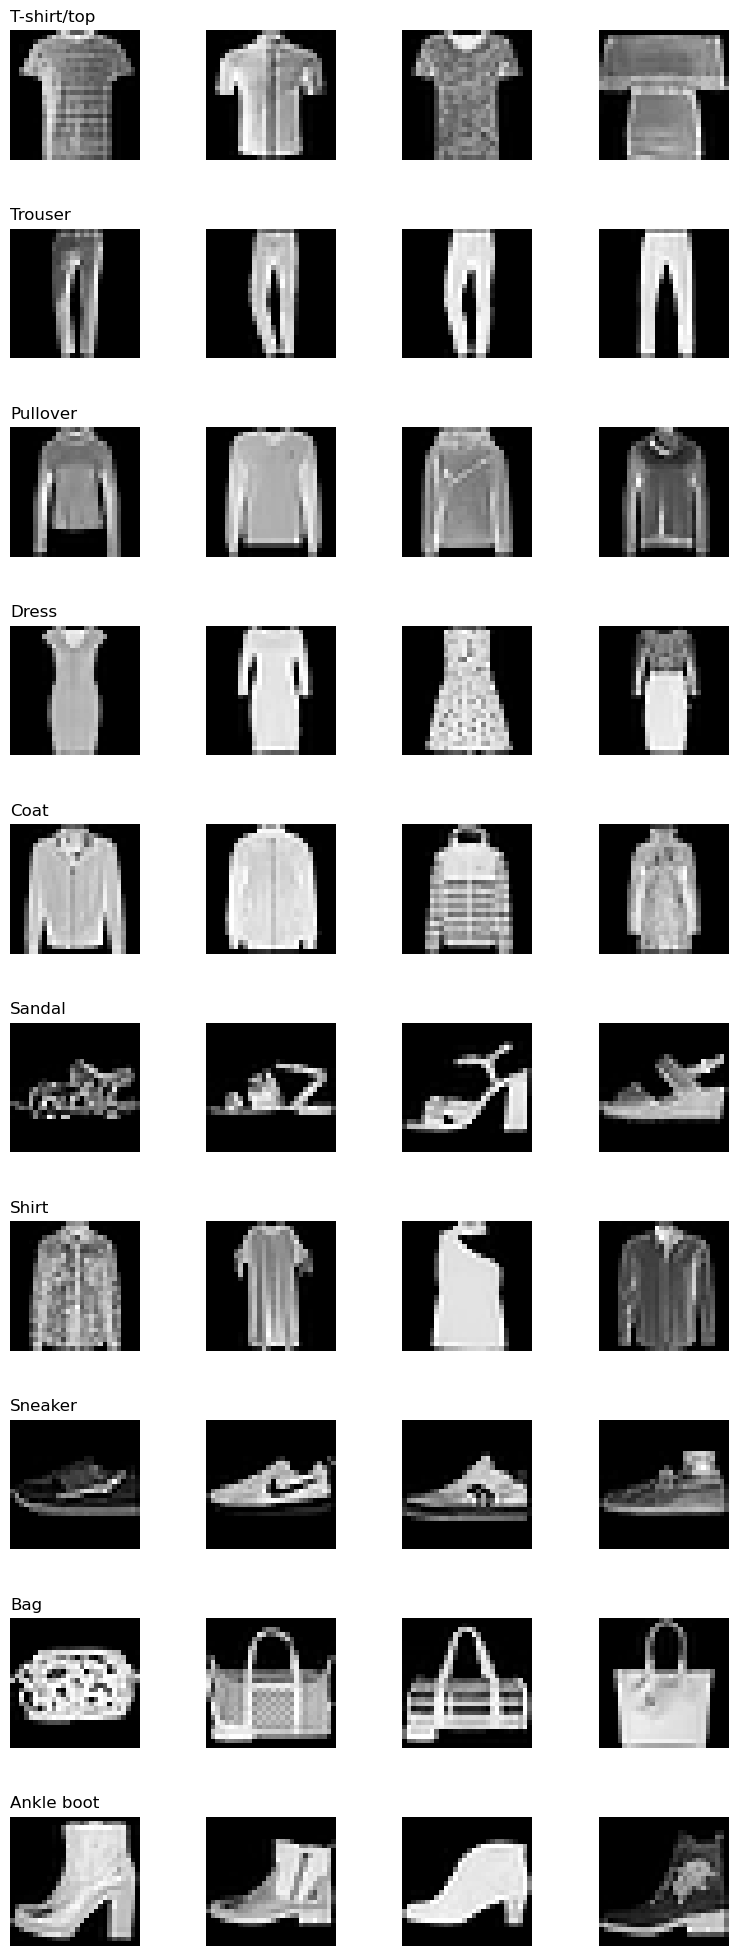

In [3]:
def visualize_data(X, y, classes_map):
    fig, axes = plt.subplots(10, 4, figsize=(8,20))
    fig.tight_layout()

    for class_id in range(10):
        class_indices = np.where(y == class_id)[0]
        selected_indices = class_indices[:4]

        for col, idx in enumerate(selected_indices):
            img = X[idx].reshape(28, 28)
            ax = axes[class_id, col]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            if col == 0:
                ax.set_title(f"{classes_map[class_id]}", loc='left')

    plt.show()


X_full, y_full, X_test = load_data()
classes = {0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat',
               5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}

visualize_data(X_full, y_full, classes)

## **Part 2**

## **Preprocessing and Helper Functions**

In [10]:
def one_hot_encode(y, num_classes=10):
    '''Converts labels to one-hot vectors'''
    return np.eye(num_classes)[y]

def softmax(z):
    z_shifted = z - np.max(z, axis=1, keepdims=True)
    exp_z = np.exp(z_shifted)
    return exp_z / np.sum(exp_z, axis=1, keepdims=True)

def train_val_split(X, y, val_ratio=0.2):
    '''Splits data into training and validation sets'''
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    split_idx = int(num_samples * (1 - val_ratio))
    train_dx, val_idx = indices[:split_idx], indices[split_idx:]
    return X[train_dx], y[train_dx], X[val_idx], y[val_idx]

def normalize_data(X_train, X_val, X_test):
    '''Normalizes pixel data to [0, 1] range'''
    max_val = 255.0
    return X_train / max_val, X_val / max_val, X_test / max_val

# Execute Preprocessing
if 'X_full' in locals():
    print("Preprocessing")
    X_train, y_train, X_val, y_val = train_val_split(X_full, y_full, val_ratio=0.2)
    X_train, X_val, X_test_norm = normalize_data(X_train, X_val, X_test)
    print(f"Train set: {X_train.shape}, Validation set: {X_val.shape}")

Preprocessing
Train set: (44800, 784), Validation set: (11200, 784)


In [5]:
class LogisticRegression:
    def __init__(self, input_dim, num_classes, lr=0.01, reg=0.0):
        self.W = np.random.randn(input_dim, num_classes) * 0.01
        self.b = np.zeros(num_classes)
        self.lr = lr
        self.reg = reg # L2 Regularization coefficient (lambda)

    def forward(self, X):
        # z = XW + b
        z = np.dot(X, self.W) + self.b
        return softmax(z)
    
    def compute_loss(self, y_true_onehot, y_pred):
        # Cross Entropy Loss + L2 Regularization
        m = y_true_onehot.shape[0]
        epsilon = 1e-15 # To prevent log(0)
        loss = -np.sum(y_true_onehot * np.log(y_pred + epsilon)) / m
        l2_loss = (self.reg / 2) * np.sum(self.W ** 2)
        return loss + l2_loss
    
    def backward(self, X, y_true_onehot, y_pred):
        m = X.shape[0]
        
        # Gradient of Loss with regards to Logits (z)
        dz = y_pred - y_true_onehot

        # Gradients with regards to Parameters
        dw = (1 / m) * np.dot(X.T, dz) + self.reg * self.W
        db = (1 / m) * np.sum(dz, axis=0)

        # Update Parameters
        self.W -= self.lr * dw
        self.b -= self.lr * db

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)

In [6]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    y_train_onehot = one_hot_encode(y_train, 10)
    y_val_onehot = one_hot_encode(y_val, 10)

    num_samples = X_train.shape[0]

    print(f"\nTraining {model.__class__.__name__}...")

    for epoch in range(epochs):
        # Shuffle data
        indices = np.arange(num_samples)
        np.random.shuffle(indices)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train_onehot[indices]

        # Mini-batch gradient descent
        for i in range(0, num_samples, batch_size):
            X_batch = X_train_shuffled[i:i+batch_size]
            y_batch = y_train_shuffled[i:i+batch_size]

            # Forward pass
            probs = model.forward(X_batch)

            # Backward pass
            if isinstance(model, LogisticRegression):
                # We pass probs because it came from the forward pass and Logistic Regression doesn't remember this for the backward pass
                model.backward(X_batch, y_batch, probs)
            else:
                # For the Neural Network the forward pass is saved so no need to pass probs
                model.backward(X_batch, y_batch)

        # Evaluation (end of epoch)
        # Train stats
        train_probs = model.forward(X_train)
        train_loss = model.compute_loss(y_train_onehot, train_probs)
        train_pred = np.argmax(train_probs, axis=1)
        train_acc = np.mean(train_pred == y_train)

        # Validation stats
        val_probs = model.forward(X_val)
        val_loss = model.compute_loss(y_val_onehot, val_probs)
        val_pred = np.argmax(val_probs, axis=1)
        val_acc = np.mean(val_pred == y_val)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        
        print(f"Epoch {epoch+1}/{epochs} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        
    return train_losses, val_losses, train_accs, val_accs

def plot_history(history, title):
    train_loss, val_loss, train_acc, val_acc = history
    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12,5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, 'b', label='Train Loss')
    plt.plot(epochs, val_loss, 'r', label='Val Loss')
    plt.title(f"{title} - Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, 'b', label='Train Acc')
    plt.plot(epochs, val_acc, 'r', label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()


--- Running Logistic Regression ---

Training LogisticRegression...
Epoch 1/20 | Val Loss: 0.5750 | Val Acc: 0.8089
Epoch 2/20 | Val Loss: 0.5241 | Val Acc: 0.8218
Epoch 3/20 | Val Loss: 0.4961 | Val Acc: 0.8334
Epoch 4/20 | Val Loss: 0.4919 | Val Acc: 0.8293
Epoch 5/20 | Val Loss: 0.4734 | Val Acc: 0.8411
Epoch 6/20 | Val Loss: 0.4701 | Val Acc: 0.8396
Epoch 7/20 | Val Loss: 0.4607 | Val Acc: 0.8440
Epoch 8/20 | Val Loss: 0.4887 | Val Acc: 0.8338
Epoch 9/20 | Val Loss: 0.4573 | Val Acc: 0.8438
Epoch 10/20 | Val Loss: 0.4544 | Val Acc: 0.8460
Epoch 11/20 | Val Loss: 0.4537 | Val Acc: 0.8456
Epoch 12/20 | Val Loss: 0.4457 | Val Acc: 0.8484
Epoch 13/20 | Val Loss: 0.4458 | Val Acc: 0.8471
Epoch 14/20 | Val Loss: 0.4553 | Val Acc: 0.8450
Epoch 15/20 | Val Loss: 0.4451 | Val Acc: 0.8475
Epoch 16/20 | Val Loss: 0.4597 | Val Acc: 0.8412
Epoch 17/20 | Val Loss: 0.4420 | Val Acc: 0.8484
Epoch 18/20 | Val Loss: 0.4767 | Val Acc: 0.8348
Epoch 19/20 | Val Loss: 0.4400 | Val Acc: 0.8519
Epoch 20/

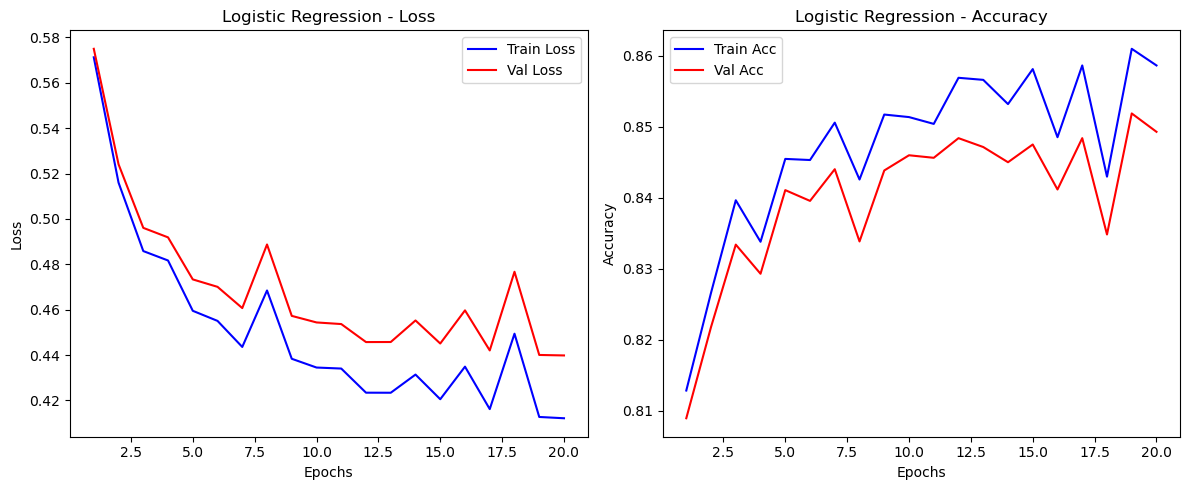

Saved lr_pred.csv


In [7]:
# Run Logistic Regression
if 'X_train' in locals():
    print('\n--- Running Logistic Regression ---')

    # Initialize model
    lr_model = LogisticRegression(input_dim=784, num_classes=10, lr=0.1, reg=0.0001)

    # Train
    lr_history = train_model(lr_model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128)

    # Plot Results
    plot_history(lr_history, 'Logistic Regression')

    # Generate and Save Predictions
    lr_preds = lr_model.predict(X_test_norm)
    np.savetxt('lr_pred.csv', lr_preds, fmt='%d')
    print('Saved lr_pred.csv')

In [8]:
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, num_classes, lr, reg):
        self.W1 = np.random.randn(input_dim, hidden_dim) * np.sqrt(2. / input_dim)
        self.b1 = np.zeros(hidden_dim)
        self.W2 = np.random.randn(hidden_dim, num_classes) * np.sqrt(2. / hidden_dim)
        self.b2 = np.zeros(num_classes)
        self.lr = lr
        self.reg = reg

    def relu(self, z):
        return np.maximum(0, z)
    
    def relu_deriv(self, z):
        return (z > 0).astype(float)
    
    def forward(self, X):
        # Layer 1
        self.z1 = np.dot(X, self.W1) + self.b1
        self.h = self.relu(self.z1)

        # Layer 2 (Output)
        self.z2 = np.dot(self.h, self.W2) + self.b2
        self.probs = softmax(self.z2)
        return self.probs
    
    def compute_loss(self, y_true_onehot, y_pred):
        m = y_true_onehot.shape[0]
        epsilon = 1e-15
        loss = -np.sum(y_true_onehot * np.log(y_pred + epsilon)) / m

        # L2 Regularization on W1 and W2
        l2_loss = (self.reg / 2) * (np.sum(self.W1 ** 2) + np.sum(self.W2 ** 2))
        return loss + l2_loss
    
    def backward(self, X, y_true_onehot):
        m = X.shape[0]

        # Output Layer Gradients
        dz2 = self.probs - y_true_onehot
        dW2 = (1/m) * np.dot(self.h.T, dz2) + self.reg * self.W2
        db2 = (1/m) * np.sum(dz2, axis=0)

        # Hidden Layer Gradients
        dh = np.dot(dz2, self.W2.T)
        dz1 = dh * self.relu_deriv(self.z1)

        dW1 = (1/m) * np.dot(X.T, dz1) + self.reg * self.W1
        db1 = (1/m) * np.sum(dz1, axis=0)
        
        # Update Weights
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1

    def predict(self, X):
        return np.argmax(self.forward(X), axis=1)


--- Running Neural Netwrok ---

Training NeuralNetwork...
Epoch 1/20 | Val Loss: 0.6640 | Val Acc: 0.8134
Epoch 2/20 | Val Loss: 0.6277 | Val Acc: 0.8296
Epoch 3/20 | Val Loss: 0.6037 | Val Acc: 0.8352
Epoch 4/20 | Val Loss: 0.5555 | Val Acc: 0.8499
Epoch 5/20 | Val Loss: 0.5285 | Val Acc: 0.8575
Epoch 6/20 | Val Loss: 0.5371 | Val Acc: 0.8521
Epoch 7/20 | Val Loss: 0.5249 | Val Acc: 0.8575
Epoch 8/20 | Val Loss: 0.5081 | Val Acc: 0.8622
Epoch 9/20 | Val Loss: 0.5118 | Val Acc: 0.8627
Epoch 10/20 | Val Loss: 0.5047 | Val Acc: 0.8583
Epoch 11/20 | Val Loss: 0.4916 | Val Acc: 0.8657
Epoch 12/20 | Val Loss: 0.4643 | Val Acc: 0.8733
Epoch 13/20 | Val Loss: 0.4630 | Val Acc: 0.8746
Epoch 14/20 | Val Loss: 0.4680 | Val Acc: 0.8706
Epoch 15/20 | Val Loss: 0.4807 | Val Acc: 0.8652
Epoch 16/20 | Val Loss: 0.4504 | Val Acc: 0.8759
Epoch 17/20 | Val Loss: 0.4626 | Val Acc: 0.8698
Epoch 18/20 | Val Loss: 0.4450 | Val Acc: 0.8763
Epoch 19/20 | Val Loss: 0.4468 | Val Acc: 0.8761
Epoch 20/20 | Val L

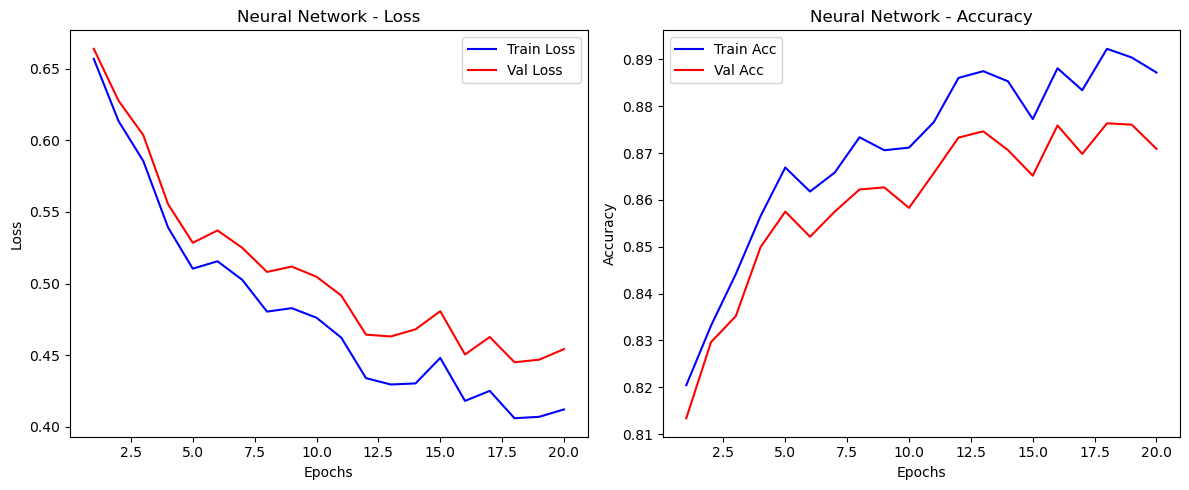

Saved NN_pred.csv


In [9]:
# Run Neural Network
if 'X_train' in  locals():
    print("\n--- Running Neural Netwrok ---")

    # Initialize Module
    nn_model = NeuralNetwork(input_dim=784, hidden_dim=128, num_classes=10, lr=0.1, reg=0.001)

    # Train
    nn_history = train_model(nn_model, X_train, y_train, X_val, y_val, epochs=20, batch_size=128)

    # Plot Results
    plot_history(nn_history, "Neural Network")

    # Generate and Save Predictions
    nn_preds = nn_model.predict(X_test_norm)
    np.savetxt("NN_pred.csv", nn_preds, fmt="%d")
    print("Saved NN_pred.csv")